<a href="https://colab.research.google.com/github/knc6/jarvis/blob/master/jarvis/db/static/jarvis_ml_quick_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JARVIS-ML model training. This notebook is designed for educational purposes only.

In [0]:
!pip install jarvis-tools lightgbm

In [0]:
from jarvis.sklearn.get_desc import get_comp_descp
from jarvis.sklearn.coulomb_mat import coulomb_matrix
from jarvis.sklearn.simple_models import bar_plot
import numpy as np
from jarvis.sklearn.build_models import jdata, regr_scores, run, get_lgbm, plot_learning_curve
plt.switch_backend('agg')
%matplotlib inline
from jarvis.db.static.explore_db import get_ml_dataset
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

#Citation: https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.2.083801
#NIST-disclaimer: https://www.nist.gov/disclaimer

### For ML, we require data and descriptors. Below, we see examples of getting descriptors for an arbitrary material. The Coulomb matrix requires the material to be primitive cell (smalles possible cell) and uses atomic number and interatomic distances. The CFID descriptor uses radial, angle, dihedral, nearest-neighbor distribution, average elemental chemical properties for the cell, and average charge descriptors. CFID should be identical or very similar for supercells, primitive cells, and conventional cells of a material. There are dedicated softwares for making descriptors such as: Matminer, Dscribe etc.

In [0]:
test_cfid_desc = get_comp_descp(dat_3d[0]['strt'])
print ('CFID',len(test_cfid_desc))
test_coul_desc = coulomb_matrix(strt=dat_3d[0]['strt'],max_dim=100)
print ('Coulomb',len(test_coul_desc))

## Exploring the data: the ML dataset consists of DFT calculated data, structure, and CFID descriptors (1557 length each) for each material.

In [0]:
dat_3d = get_ml_dataset()


In [77]:
# Size of the data
len(dat_3d)

24759

In [0]:
#Available keys

In [79]:
dat_3d[0].keys()

dict_keys(['gv', 'mpid', 'hl_mass_z', 'hl_mass_y', 'hl_mass_x', 'op_gap', 'encut', 'form_enp', 'strt', 'mbj_gap', 'jid', 'el_mass_z', 'el_mass_x', 'el_mass_y', 'kp_leng', 'epsz', 'epsx', 'epsy', 'multi_elastic', 'type', 'fin_enp', 'el_mass', 'desc', 'magmom', 'exfoliation_en', 'hl_mass', 'mepsz', 'mepsx', 'mepsy', 'kv'])

In [0]:
pprint.pprint(dat_3d[0])

In [0]:
# desc: 1557 descriptors
# form_enp: formation energy per atom (eV/atom)
# op_gap: OptB88vdW functional based bandgap (eV)
# mbj_gap: TBmBJ functional based bandgap (eV)
# kv: Voigt bulk mod. (GPa)
# gv: Shear bulk mod. (GPa)
# elastic: elastic tensor instring format, use the function 'get_et' to convert into pymatgen elastictensor object
# epsx: Static dielctric function value in x-direction based on OptB88vdW (no unit)
# mepsx: Static dielctric function value in x-direction based on TBmBJ (no unit)
# magmom: Magnetic moment (Bohr magneton) [from OUTCAR and from OSZICAR], generally OSZICAR value is preferred
# kp_leng: Kpoint automatic line density obtained after automatic convergence (Angstrom), substract 25 because 5 extra points were taken during convergence
# encut: Plane wave cut-off value obtained after automatic convergence
# exfoliation_en: exfoliation energy
# strt: final structure after relaxation with OptB88vdW
# el/hl_mass: effective mass with BoltzTrap at 300K for electrons/holes
#'na' signifies non-available data

In [83]:
#Avilable data 
keys=['gv','kv','fin_enp','op_gap','mbj_gap','magmom','epsx','epsy','epsz','mepsx','mepsy','mepsz','hl_mass','form_enp','exfoliation_en']
info={}
for i in dat_3d:
  for j in keys:
     if i[j]!='na' and i[j]!={}:
            info.setdefault(j, []).append(i['jid'])
for i,j in info.items():
    print (i,len(j))


fin_enp 24759
op_gap 22394
magmom 24759
hl_mass 19978
form_enp 24759
mbj_gap 7055
mepsx 10560
mepsy 10560
mepsz 10560
exfoliation_en 564


# Quick ML training example for formation energy

### The "jdata" module gives descriptors and target data from the JARVIS-ML dataset

In [84]:
x,y,jid=jdata(prop='form_enp')

Prop= form_enp 24759 24759


## Let's train a simple linear regression model first

In [0]:
model = LinearRegression()


##We split the data into train and test sets. We can train the model with the train-data and predict using ML model for the test data.

In [86]:
X_train, X_test, y_train, y_test,jid_train,jid_test = train_test_split(x, y,jid, random_state=1, test_size=0.1)
print (len(X_train), len(X_test))


22283 2476


##Let's take 500 of training set as a quick example

In [87]:
X1=X_train[0:500]
Y1=y_train[0:500]
X2=X_test[0:500]
Y2=y_test[0:500]
print ('descriptor size',len(X1[0]))


descriptor size 1557


## Scikit-learn and related ML models have "fit" and "predict" methods. 

In [88]:
model.fit(X1,Y1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Let's predict for the held data

In [0]:
pred=model.predict(X2)

###The "regr_score" function gives regression relation metrics data

Text(0, 0.5, 'ML-Formation energy (eV/atom)')

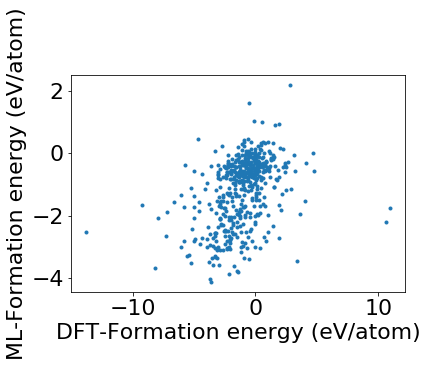

In [90]:
reg_sc=regr_scores(Y2,pred)
plt.plot(reg_sc['test'],reg_sc['pred'],'.')
plt.xlabel('DFT-Formation energy (eV/atom)')
plt.ylabel('ML-Formation energy (eV/atom)')

###Let's plot learning curve to see whether the model improves as we add more data. Also, this helps in guessing whether the model is under vs overfitting.

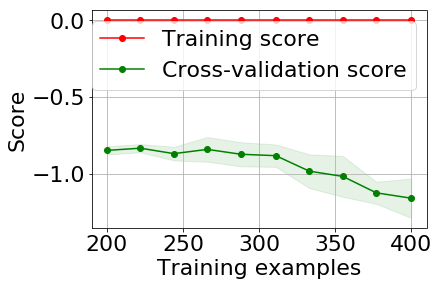

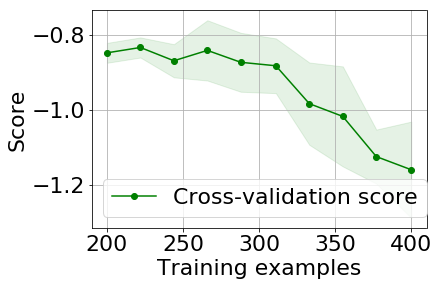

{'test_scores_mean': array([-0.84862532, -0.83428236, -0.86971367, -0.84205476, -0.87384708,
        -0.88306234, -0.98412703, -1.01815822, -1.12528757, -1.16044333]),
 'test_scores_std': array([0.02654085, 0.02682818, 0.04419794, 0.08041249, 0.07859878,
        0.07301228, 0.10978655, 0.13339467, 0.07202428, 0.1284626 ]),
 'train_scores_mean': array([-2.47578325e-11, -1.49290711e-11, -1.42649371e-11, -1.74809690e-11,
        -4.32416496e-11, -1.40712572e-11, -1.89909853e-11, -1.48630793e-11,
        -2.08317095e-11, -2.93929010e-11]),
 'train_scores_std': array([1.45753591e-11, 3.15604291e-12, 4.15362228e-12, 1.84065909e-11,
        2.93122053e-11, 9.84157158e-12, 1.27522227e-11, 1.08984119e-11,
        1.21755951e-11, 1.63047922e-11]),
 'train_sizes': array([200, 222, 244, 266, 288, 311, 333, 355, 377, 400])}

In [91]:
plot_learning_curve(estimator=model,X=X,y=Y,train_sizes=np.linspace(0.5, 1.0, 10))

# Now let's try LightGBM model.

Text(0, 0.5, 'ML-Formation energy (eV/atom)')

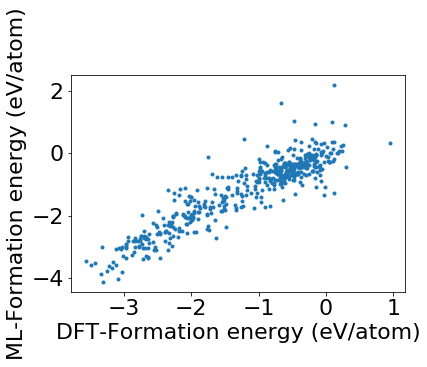

In [92]:

model = lgb.LGBMRegressor(
                    n_estimators=100,
                    learning_rate=0.1,
                    max_depth=5,
                    num_leaves=100,
                    objective='regression',
                    n_jobs=-1,
                    verbose=-1
                   )

model.fit(X1,Y1)
pred=model.predict(X2)
reg_sc=regr_scores(Y2,pred)
plt.plot(reg_sc['test'],reg_sc['pred'],'.')
plt.xlabel('DFT-Formation energy (eV/atom)')
plt.ylabel('ML-Formation energy (eV/atom)')

###Let's plot learning curve to see whether the model improves as we add more data. Also, this helps in guessing whether the model is under vs overfitting.

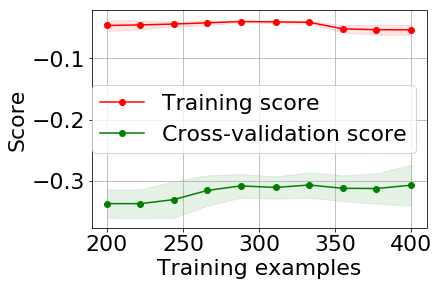

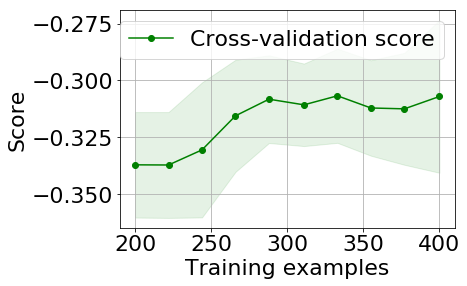

{'test_scores_mean': array([-0.33709027, -0.33716226, -0.33053044, -0.31555346, -0.3082518 ,
        -0.31072502, -0.30676033, -0.31211315, -0.31248712, -0.30706288]),
 'test_scores_std': array([0.02317431, 0.02325632, 0.02967293, 0.02462823, 0.01924897,
        0.0181268 , 0.02067401, 0.0209747 , 0.02458953, 0.03350736]),
 'train_scores_mean': array([-0.04661633, -0.04566734, -0.04427018, -0.04230299, -0.04015368,
        -0.04075912, -0.04142096, -0.05212321, -0.05348415, -0.05369933]),
 'train_scores_std': array([0.00853676, 0.00741463, 0.00387287, 0.00422703, 0.00089438,
        0.00212943, 0.00234468, 0.00588187, 0.0080831 , 0.00803755]),
 'train_sizes': array([200, 222, 244, 266, 288, 311, 333, 355, 377, 400])}

In [93]:
plot_learning_curve(estimator=model,X=X,y=Y,train_sizes=np.linspace(0.5, 1.0, 10))

# Visualization with manifold t-SNE

In [94]:
from sklearn import decomposition,manifold
pca = decomposition.PCA(n_components=30)
Z_pca = pca.fit_transform(X)

# note: scikit-learn docs are incorrect when they state that perplexity isn't an important hyperparameter...
sne = manifold.TSNE(perplexity=.1, verbose=True)
sne.fit(Z_pca)

[t-SNE] Computing 1 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.812953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.625946
[t-SNE] KL divergence after 1000 iterations: 0.437145


TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=0.1,
     random_state=None, verbose=True)

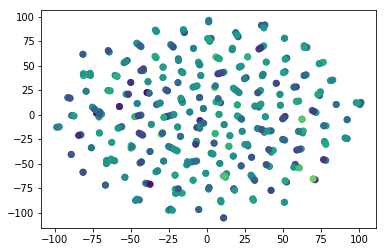

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(sne.embedding_[:,0],sne.embedding_[:,1],c=Y)
plt.show()